# DarwinAI Build SDK Demo (PyTorch)
<br>
<font size= 4>
This notebook demonstrates the DarwinAI Build SDK for automatically generating tailored, optimized model architectures based on operational requirements.  DarwinAI Build SDK can be used to automatically generate optimized models under different scenarios such as during the early prototyping stage before training and at the design stage after an initial model prototype has been created and trained.  In this demo, we will illustrate how the Build SDK can be used under the scenario where: 
<br>
<ol>
  <li>the developer has already created a pre-trained model prototype as initial condition, and</li>
  <li>the developer specifies an operational target based on FLOPs.</li>
</ol>
Here, we will specify two different FLOPs targets and have Build SDK automatically generate two optimized PyTorch models.  Finally, we will output the performance specifications (e.g., number of parameters, number of FLOPs for inference) for the two generated optimized models.
</font>

In [1]:
import torch
import torchvision.models as models
from PIL import Image
import numpy as np
from thop import profile
import math

NUM_CLASSES = 3

In [2]:
# DarwinAI Build SDK imports
from darwinai.torch.builder import build_model
from darwinai.builder import BlockSpec

22-02-15 00:01:09.507|INFO|<frozen importlib._bootstrap>|_load_backward_compatible|618|Licenser|License is already activated.


The DarwinAI troubleshooting mode is active and debug logs are stored at /home/tia.tuinstra/COVID-Net-pt/logs/darwin_sdk_2022-02-15T00:01:09.debug.


In [3]:
# For this demo, we will use a ResNet as the model prototype as initial condition, which is defined in the resnet.py file
from resnet import ResNet

In [4]:
# Utility functions
def get_params(model):
    """Calculates the total parameters in the model"""
    total_parameters = 0
    for param in model.parameters():
        total_parameters += np.prod(param.size())
    return total_parameters

def get_flops(model, input_shape):
    """Calculates the flops in the model"""
    dummy_inputs = torch.zeros(*input_shape)
    flops = profile(model, inputs=(dummy_inputs,), verbose=False)[0]
    return math.floor(flops)

<font size= 4>
The DarwinAI Build SDK requires the user to provide a function that returns a model. This function takes in a list of BlockSpecs, which is just a simple structure that defines the architectural properties of a sub-component in the model's architecture (e.g., number of blocks in a sub-component, number of channels within each block of a sub-component, etc.). The architectural properties defined in BlockSpecs helps establish the design exploration space for Build SDK to explore in an automated and efficient fashion during the machine-driven design exploration phase.
</font>

In [16]:
def make_model(blockspecs):
    num_classes = NUM_CLASSES
    return ResNet(blockspecs, num_classes)

In [17]:
# The initial conditions of the model prototype is defined with respect to the following 
#BlockSpecs. See the ResNet class implementation for additional details in resnet.py
initial_blockspecs = [
    BlockSpec(channels=64, depth=3),
    BlockSpec(channels=128, depth=4),
    BlockSpec(channels=256, depth=6),
    BlockSpec(channels=512, depth=3),
]
# To enable the Build SDK to learn from both the model prototype but also its associated knowledge, 
# we create an additional ResNet model that loads ImageNet pretrained weights. Build SDK learns from 
# knowledge captured in the pretrained weights to generate the optimized model during the design exploration phase. 
baseline_pretrained_model = models.resnet50(pretrained=True)
num_ftrs = baseline_pretrained_model.fc.in_features
baseline_pretrained_model.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)
baseline_pretrained_model.load_state_dict(torch.load('./output/covid_net_model-geo/model'))


baseline_pretrained_model.eval()
input_shape = [1, 3, 224, 224]

print("Architecture properties of initial model prototype:")
print("Number of Parameters: ", get_params(baseline_pretrained_model))
print("Number of FLOPs: ", get_flops(baseline_pretrained_model, input_shape))
print("\t\t Num Blocks \t Channels per Block")
for b, blkspec in enumerate(initial_blockspecs):
    print("Stage {} \t {} \t\t {}".format(b, blkspec.depth, blkspec.channels))

Architecture properties of initial model prototype:
Number of Parameters:  23514179
Number of FLOPs:  4109472768
		 Num Blocks 	 Channels per Block
Stage 0 	 3 		 64
Stage 1 	 4 		 128
Stage 2 	 6 		 256
Stage 3 	 3 		 512


In [18]:
target_flops_ratio = 0.5
# The build_model function returns a generated optimized model based on the desired performance target.
# Here we first generate an optimized model based on a FLOPS target of 50% relative to initial model prototype.
# The newly generated optimized model can then be further trained or fine-tuned.
print('Generating optimized model...')
model = build_model(
    make_model,
    initial_blockspecs,
    input_shape,
    target_flops_ratio,
    pretrained_model=baseline_pretrained_model,
)
print('Done generating optimized model.')

Generating optimized model...
Done generating optimized model.


In [19]:
# The newly generated optimized model's architecture is different than the initial model prototype
print("Architecture properties of generated optimized model at a target FLOPs ratio of {}:".format(target_flops_ratio))
print("Number of Parameters: ", get_params(model))
print("Number of FLOPs: ", get_flops(model, input_shape))

print("\t\t Num Blocks \t Channels per Block")
for b, blkspec in enumerate(model.blockspecs):
    print("Stage {} \t {} \t\t {}".format(b, blkspec.depth, blkspec.channels))

Architecture properties of generated optimized model at a target FLOPs ratio of 0.5:
Number of Parameters:  11249228
Number of FLOPs:  2036724776
		 Num Blocks 	 Channels per Block
Stage 0 	 2 		 51
Stage 1 	 3 		 103
Stage 2 	 4 		 208
Stage 3 	 2 		 428


<font size= 4>
The generated optimized model is now ready to be further trained or fine-tuned then deployed using your preferred deployment toolkits (TensorRT, OpenVINO, etc.). There are no custom or proprietary artifacts in the model, and so deployment compatibility for the newly generated model remains the same as the initial model prototype.
<br>
<br>
Let us now generate a second optimized model at a different performance target (FLOPS target of 20% relative to initial model prototype).
</font>

In [20]:
# We will now re-run Build SDK, but this time generate an optimized model based on a different performance target.
target_flops_ratio = 0.2
# In this demo, we now generate an optimized model based on a FLOPS target of 20% relative to initial model prototype.
# The newly generated optimized model can then be further trained or fine-tuned.

print('Generating model...')
model2 = build_model(
    make_model,
    initial_blockspecs,
    input_shape,
    target_flops_ratio,
    pretrained_model=baseline_pretrained_model,
)
print('Done generating model.')
print("Architecture properties of generated optimized model at a target FLOPs ratio of {}:".format(target_flops_ratio))
print("Number of Parameters: ", get_params(model2))
print("Number of FLOPs: ", get_flops(model2, input_shape))

print("\t\t Num Blocks \t Channels per Block")
for b, blkspec in enumerate(model2.blockspecs):
    print("Stage {} \t {} \t\t {}".format(b, blkspec.depth, blkspec.channels))

Generating model...
Done generating model.
Architecture properties of generated optimized model at a target FLOPs ratio of 0.2:
Number of Parameters:  3888956
Number of FLOPs:  814206824
		 Num Blocks 	 Channels per Block
Stage 0 	 1 		 35
Stage 1 	 2 		 72
Stage 2 	 3 		 150
Stage 3 	 1 		 324


In [21]:
import pathlib
import os
target_flops_ratio = 0.2

save_path = './models/gensynth_resnet_' + str(target_flops_ratio) + 'tfr'

pathlib.Path(save_path).mkdir(parents=True, exist_ok=True)
torch.save(model2.state_dict(), os.path.join(save_path, 'model'))

In [36]:
import copy
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

import warnings
warnings.filterwarnings('ignore')
 
from dataset import get_dataloader

NUM_CLASSES = 3
BATCH_SIZE = 16

datadir = '../montefiore_severity/CXR'
trainfile = '../../alex.maclean/montefiore_severity/nov_29_split_80_10_10/train_mtf_sev.txt'
validfile = '../../alex.maclean/montefiore_severity/nov_29_split_80_10_10/valid_mtf_sev.txt'
testfile = '../../alex.maclean/montefiore_severity/nov_29_split_80_10_10/test_mtf_sev.txt'
name = 'covid_net_model'
modelfile = None

# Check which metric to use
measure = 'geo' 

bin_map = np.array([[0.0,3.0], [3.0,6.0], [6.0,8.0]])
is_classification = True

target_flops_ratio = 0.5
 
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
 
    
# output path
output_path = './output/'
run_id = 'gensynth_resnet_' + str(target_flops_ratio) + 'tfr_' + name + f'-{measure}'
run_path = output_path + run_id
pathlib.Path(run_path).mkdir(parents=True, exist_ok=True)
print('Output: ' + run_path)
 

train_dataloader = get_dataloader(
        csv_file=trainfile,
        datadir=datadir,
        batch_size=BATCH_SIZE,
        transform='base',
        bin_map=bin_map,
        is_classification=is_classification)
 
valid_dataloader = get_dataloader(
        csv_file=validfile,
        datadir=datadir,
        batch_size=1,
        transform=None,
        bin_map=bin_map,
        is_classification=is_classification) # no augmentations
 
dataloaders = {'train':train_dataloader, 'val':valid_dataloader}
dataset_sizes = {'train':len(train_dataloader)*BATCH_SIZE, 'val':len(valid_dataloader)}

train_acc = []
train_loss = []
val_acc = []
val_loss = []
 
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    '''taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html '''
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())

    best_acc = 0.0
 
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
 
        epoch_start = time.time()
 
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
 
            running_loss = 0.0
            running_corrects = 0
 
            for i, sample_batch in enumerate(dataloaders[phase]):
                inputs = sample_batch['image'].to(device, dtype=torch.float)
                # CXR sev to get OPC or GEO
                labels = sample_batch['label'][measure].to(device, dtype=torch.long)
                
                optimizer.zero_grad()
 
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
 
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
 
                if i % 100 == 0 and phase == 'train':
                    phase_batch = BATCH_SIZE if phase == 'train' else 1
                    print('Batch {} of {}'.format(i, dataset_sizes[phase]/phase_batch))
            if phase == 'train':
                scheduler.step()
 
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
 
            if phase == 'train':
                train_acc.append(epoch_acc)
                train_loss.append(epoch_loss)
            else:
                val_acc.append(epoch_acc)
                val_loss.append(epoch_loss)
    
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print('Epoch took {} seconds'.format(time.time() - epoch_start))
 
        print()
 
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
 
model_ft = model
#num_ftrs = model_ft.fc.in_features
 
#print(num_ftrs)

#model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)

model_ft = model_ft.to(device)
 
# initial basic training parameters
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
 
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)
 
torch.save(model_ft.state_dict(), os.path.join(run_path, 'model'))
 



Output: ./output/gensynth_resnet_0.5tfr_covid_net_model-geo
Epoch 0/19
----------
Batch 0 of 120.0
Batch 100 of 120.0
train Loss: 0.7790 Acc: 0.6219
val Loss: 0.8378 Acc: 0.5633
Epoch took 122.95534801483154 seconds

Epoch 1/19
----------
Batch 0 of 120.0
Batch 100 of 120.0
train Loss: 0.6462 Acc: 0.7063
val Loss: 0.7649 Acc: 0.6507
Epoch took 121.96569561958313 seconds

Epoch 2/19
----------
Batch 0 of 120.0
Batch 100 of 120.0
train Loss: 0.6311 Acc: 0.7016
val Loss: 0.8327 Acc: 0.5939
Epoch took 123.5315613746643 seconds

Epoch 3/19
----------
Batch 0 of 120.0
Batch 100 of 120.0
train Loss: 0.5790 Acc: 0.7240
val Loss: 1.1946 Acc: 0.4629
Epoch took 121.75552582740784 seconds

Epoch 4/19
----------
Batch 0 of 120.0
Batch 100 of 120.0
train Loss: 0.5676 Acc: 0.7375
val Loss: 0.7763 Acc: 0.6725
Epoch took 122.21567630767822 seconds

Epoch 5/19
----------
Batch 0 of 120.0
Batch 100 of 120.0
train Loss: 0.5368 Acc: 0.7495
val Loss: 0.8966 Acc: 0.5852
Epoch took 121.18999814987183 seconds


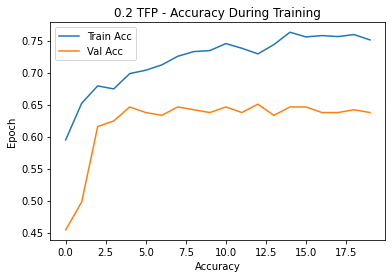

Text(0.5, 1.0, '0.2 TFP - Loss During Training')

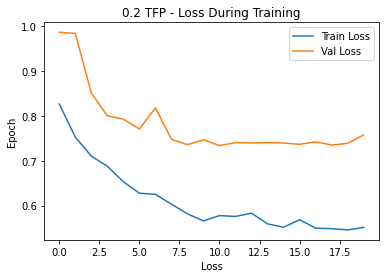

In [35]:
import matplotlib.pyplot as plt


plt.plot(train_acc2)
plt.plot(val_acc2)
plt.legend(['Train Acc', 'Val Acc'])
plt.ylabel('Epoch')
plt.xlabel('Accuracy')
plt.title('0.2 TFP - Accuracy During Training')

plt.show()

plt.plot(train_loss2)
plt.plot(val_loss2)
plt.legend(['Train Loss', 'Val Loss'])
plt.ylabel('Epoch')
plt.xlabel('Loss')
plt.title('0.2 TFP - Loss During Training')

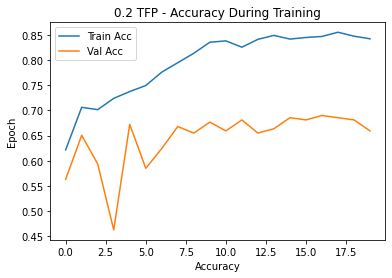

Text(0.5, 1.0, '0.2 TFP - Loss During Training')

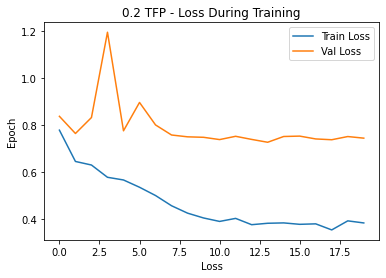

In [37]:
import matplotlib.pyplot as plt


plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['Train Acc', 'Val Acc'])
plt.ylabel('Epoch')
plt.xlabel('Accuracy')
plt.title('0.5 TFP - Accuracy During Training')

plt.show()

plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['Train Loss', 'Val Loss'])
plt.ylabel('Epoch')
plt.xlabel('Loss')
plt.title('0.5 TFP - Loss During Training')

In [40]:
for b, blkspec in enumerate(model2.blockspecs):
    print(blkspec)
    print("Stage {} \t {} \t\t {}".format(b, blkspec.depth, blkspec.channels))

Stage 0 	 1 		 35
Stage 1 	 2 		 72
Stage 2 	 3 		 150
Stage 3 	 1 		 324
